In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense
# sns.set_style("whitegrid")
plt.style.use('seaborn')

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# base_dir = 'd:/GitHub/python-2-work/' # work
base_dir = 'd:/SRC/ensemble-forecasting/'  # home
h = np.loadtxt(base_dir + 'data/2011/2011080100_hiromb_GI_60x434.txt') - 37.356
s = np.loadtxt(base_dir + 'data/2011/2011080100_swan_GI_48x434.txt')
n = np.loadtxt(base_dir + 'data/2011/2011080100_noswan_GI_48x434.txt')
m = np.loadtxt(base_dir + 'data/2011/2011080100_measurements_GI_2623.txt')

# forecast dimensions
N = 100 # 430
T = 48

# preparing measurements forecast
m_fc = np.zeros((N, T+1))
for i in range(N):
    for j in range(T+1):
        m_fc[i, j] = m[i*6+j]

# data cut and shifting
shift_const = 0
h = h[0:N, 1:T+1] + shift_const
s = s[0:N, 1:T+1] + shift_const
n = n[0:N, 1:T+1] + shift_const
m_fc = m_fc[0:N, 1:T+1] + shift_const
h.shape, s.shape, n.shape, m_fc.shape

((100, 48), (100, 48), (100, 48), (100, 48))

In [3]:
errors_log = []
a = opt.minimize(lambda a: np.mean(np.abs(a[0] + a[1]*h + a[2]*s - m_fc)), [0, 0.5, 0.5]).x
ens = a[0] + a[1]*h + a[2]*s                         
def plot_ensemble(q):
    plt.figure()
    plt.plot(h[q], 'r-')
    plt.plot(s[q], 'g-')
    plt.plot(m_fc[q], 'ko')
    plt.plot(ens[q], 'm-', linewidth=2)
    plt.title('h:{0:.2f} s:{1:.2f} ens:{2:.2f}'.format(np.mean(np.abs(h[q] - m_fc[q])),
              np.mean(np.abs(s[q] - m_fc[q])), 
              np.mean(np.abs(ens[q] - m_fc[q]))))
errors_log.append(('Basic ensemble', np.mean(np.abs(ens - m_fc), axis=1)))
a

array([4.4358698 , 0.60883759, 0.28888977])

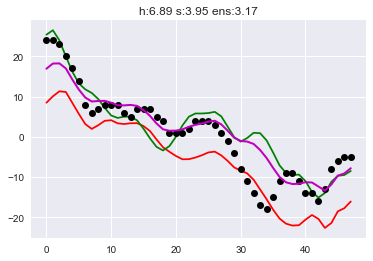

In [4]:
plot_ensemble(50)

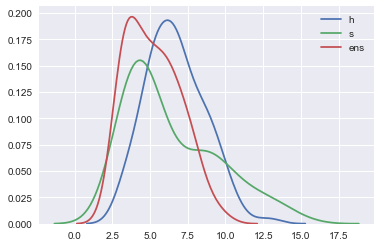

In [5]:
sns.kdeplot(np.mean(np.abs(h - m_fc), axis=1), label='h')
sns.kdeplot(np.mean(np.abs(s - m_fc), axis=1), label='s')
sns.kdeplot(np.mean(np.abs(ens - m_fc), axis=1), label='ens')

# Baseline ANN

In [6]:
%%time
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf

def baseline_ann_ensemble():
    model = Sequential()
    model.add(Dense(units=2, kernel_initializer='normal', activation='relu', input_dim=2))
    model.add(Dense(units=1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

with tf.device('/cpu:0'):
    X = np.vstack((h.flatten(), s.flatten())).transpose()
    Y = m_fc.flatten()
    seed = 7
    np.random.seed(seed)
    estimator = KerasRegressor(build_fn=baseline_ann_ensemble, epochs=100, batch_size=10, verbose=0)
    kfold = KFold(n_splits=10, random_state=seed)
    results = cross_val_score(estimator, X, Y, cv=kfold)
    print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -52.76 (26.59) MSE
Wall time: 4min 11s


In [7]:
%%time
with tf.device('/cpu:0'):
    estimator.fit(X, Y)
    estimator.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Wall time: 28.5 s


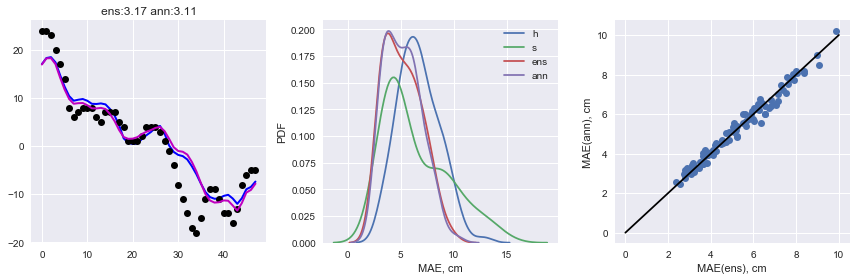

In [8]:
predicted = np.array([estimator.predict(np.array([h[q], s[q]]).transpose()) for q in range(N)])
def plot_summary(t_h, t_s, t_ens, t_m_fc, t_predicted, t_q):
    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.plot(t_predicted[t_q], 'b-', linewidth=2)
    plt.plot(t_m_fc[t_q], 'ko')
    plt.plot(t_ens[t_q], 'm-', linewidth=2)
    plt.title('ens:{0:.2f} ann:{1:.2f}'.format(np.mean(np.abs(t_ens[t_q] - t_m_fc[t_q])), 
                                               np.mean(np.abs(t_predicted[t_q] - t_m_fc[t_q]))))
    plt.subplot(132)
    sns.kdeplot(np.mean(np.abs(t_h - t_m_fc), axis=1), label='h')
    sns.kdeplot(np.mean(np.abs(t_s - t_m_fc), axis=1), label='s')
    sns.kdeplot(np.mean(np.abs(t_ens - t_m_fc), axis=1), label='ens')
    sns.kdeplot(np.mean(np.abs(t_predicted - t_m_fc), axis=1), label='ann')
    plt.xlabel('MAE, cm')
    plt.ylabel('PDF')
    plt.subplot(133)
    plt.plot(np.mean(np.abs(t_ens - t_m_fc), axis=1), np.mean(np.abs(t_predicted - t_m_fc), axis=1), 'o')
    plt.plot([0,10], [0,10], 'k-')
    plt.xlabel('MAE(ens), cm')
    plt.ylabel('MAE(ann), cm')
    plt.tight_layout()
errors_log.append(('ANN ensemble', np.mean(np.abs(predicted - m_fc), axis=1)))
plot_summary(h, s, ens, m_fc, predicted, 50)

## Standartize

In [9]:
%%time
with tf.device('/cpu:0'):
    np.random.seed(seed)
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('mlp', KerasRegressor(build_fn=baseline_ann_ensemble, epochs=100, batch_size=10, verbose=0)))
    pipeline = Pipeline(estimators)
    kfold = KFold(n_splits=10, random_state=seed)
    results = cross_val_score(pipeline, X, Y, cv=kfold)
    print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -51.39 (26.04) MSE
Wall time: 4min 37s


In [10]:
%%time
with tf.device('/cpu:0'):
    pipeline.fit(X,Y)

Wall time: 30.8 s


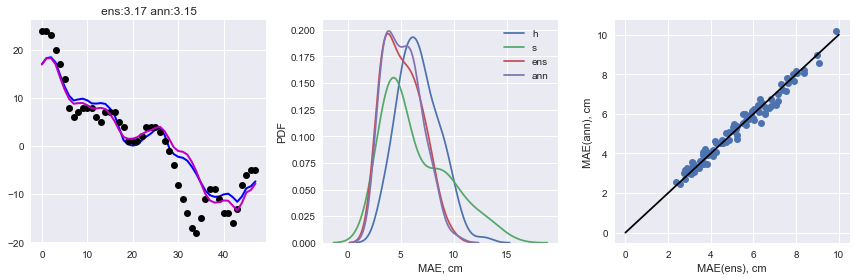

In [11]:
predicted = np.array([pipeline.predict(np.array([h[q], s[q]]).transpose()) for q in range(N)])
errors_log.append(('ANN ensemble + stadartize', np.mean(np.abs(predicted - m_fc), axis=1)))
plot_summary(h, s, ens, m_fc, predicted, 50)

# Whole-forecast ensemble

In [12]:
%%time
def whole_fc_ann_ensemble():
    model = Sequential()
    model.add(Dense(units=T*2, kernel_initializer='normal', activation='relu', input_dim=T*2))
    model.add(Dense(units=T, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
with tf.device('/cpu:0'):
    X = np.hstack((h, s))
    Y = m_fc
    seed = 7
    np.random.seed(seed)
    # epochs and batch_size tuned manually
    estimator = KerasRegressor(build_fn=whole_fc_ann_ensemble, epochs=15, batch_size=12, verbose=0)
    kfold = KFold(n_splits=10, random_state=seed)
    results = cross_val_score(estimator, X, Y, cv=kfold)
    print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -51.05 (24.90) MSE
Wall time: 9.07 s


In [13]:
%%time
with tf.device('/cpu:0'):
    estimator.fit(X, Y)
    estimator.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 96)                9312      
_________________________________________________________________
dense_66 (Dense)             (None, 48)                4656      
Total params: 13,968
Trainable params: 13,968
Non-trainable params: 0
_________________________________________________________________
Wall time: 793 ms


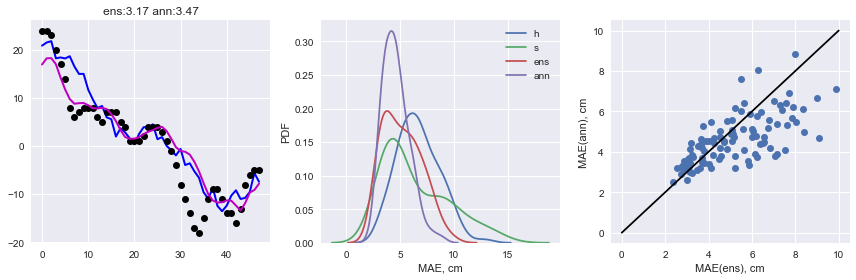

In [14]:
predicted = estimator.predict(X)
errors_log.append(('ANN whole-forecast ensemble', np.mean(np.abs(predicted - m_fc), axis=1)))
plot_summary(h, s, ens, m_fc, predicted, 50)

## Deeper network

In [15]:
%%time
def whole_fc_ann_ensemble():
    model = Sequential()
    model.add(Dense(units=T*2, kernel_initializer='normal', activation='relu', input_dim=T*2))
    model.add(Dense(units=T, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=T, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
with tf.device('/cpu:0'):
    X = np.hstack((h, s))
    Y = m_fc
    # for e in range(10,101,10):
    # Results (e: 10): -67.10 (46.96) MSE
    # Results (e: 20): -56.83 (29.00) MSE
    # Results (e: 30): -53.41 (28.03) MSE
    # Results (e: 40): -57.66 (31.38) MSE
    seed = 7
    np.random.seed(seed)
    # epochs and batch_size tuned manually
    estimator = KerasRegressor(build_fn=whole_fc_ann_ensemble, epochs=30, batch_size=10, verbose=0)
    kfold = KFold(n_splits=10, random_state=seed)
    results = cross_val_score(estimator, X, Y, cv=kfold)
    print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -53.48 (28.19) MSE
Wall time: 13.8 s


In [16]:
%%time
with tf.device('/cpu:0'):
    estimator.fit(X, Y)
    estimator.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 96)                9312      
_________________________________________________________________
dense_98 (Dense)             (None, 48)                4656      
_________________________________________________________________
dense_99 (Dense)             (None, 48)                2352      
Total params: 16,320
Trainable params: 16,320
Non-trainable params: 0
_________________________________________________________________
Wall time: 1.41 s


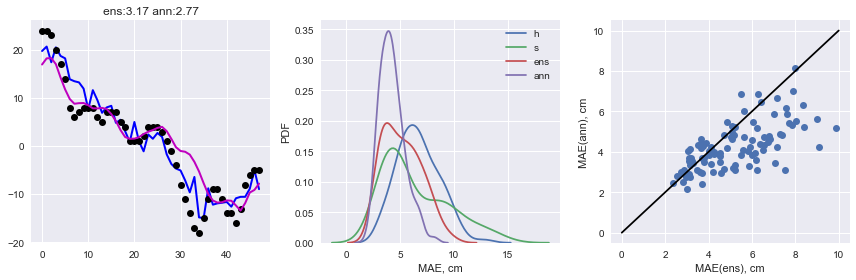

In [17]:
predicted = estimator.predict(X)
errors_log.append(('ANN (deeper) whole-forecast ensemble', np.mean(np.abs(predicted - m_fc), axis=1)))
plot_summary(h, s, ens, m_fc, predicted, 50)

# Wider network

In [18]:
%%time
def whole_fc_ann_ensemble():
    model = Sequential()
    model.add(Dense(units=T*4, kernel_initializer='normal', activation='relu', input_dim=T*2))
    model.add(Dense(units=T, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
with tf.device('/cpu:0'):
    X = np.hstack((h, s))
    Y = m_fc
    # for e in range(10,101,10):
    # Results (e: 10): -67.10 (46.96) MSE
    # Results (e: 20): -56.83 (29.00) MSE
    # Results (e: 30): -53.41 (28.03) MSE
    # Results (e: 40): -57.66 (31.38) MSE
    seed = 7
    np.random.seed(seed)
    # epochs and batch_size tuned manually
    estimator = KerasRegressor(build_fn=whole_fc_ann_ensemble, epochs=20, batch_size=10, verbose=0)
    kfold = KFold(n_splits=10, random_state=seed)
    results = cross_val_score(estimator, X, Y, cv=kfold)
    print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -52.91 (29.30) MSE
Wall time: 15.7 s


In [19]:
%%time
with tf.device('/cpu:0'):
    estimator.fit(X, Y)
    estimator.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_120 (Dense)            (None, 192)               18624     
_________________________________________________________________
dense_121 (Dense)            (None, 48)                9264      
Total params: 27,888
Trainable params: 27,888
Non-trainable params: 0
_________________________________________________________________
Wall time: 1.32 s


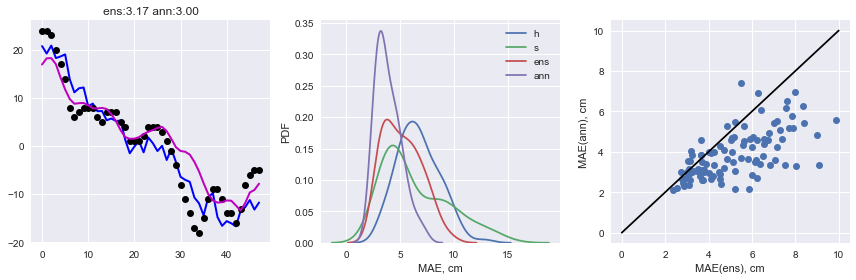

In [20]:
predicted = estimator.predict(X)
errors_log.append(('ANN (wider) whole-forecast ensemble', np.mean(np.abs(predicted - m_fc), axis=1)))
plot_summary(h, s, ens, m_fc, predicted, 50)

# Adding observations and frequencies

In [21]:
freq = np.absolute(np.fft.fft(m_fc[:,-32:], axis=1)[:,0:16])
freq.shape

(100, 16)

In [22]:
%%time
def whole_fc_m_ann_ensemble():
    model = Sequential()
    model.add(Dense(units=T*3+16, kernel_initializer='normal', activation='relu', input_dim=T*3+16))
    model.add(Dense(units=T*3, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=T, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
with tf.device('/cpu:0'):
    X = np.hstack((h[8:], s[8:], m_fc[:-8], freq[:-8]))
    Y = m_fc[8:]
    seed = 7
    np.random.seed(seed)
    estimator = KerasRegressor(build_fn=whole_fc_m_ann_ensemble, epochs=14, batch_size=10, verbose=0)
    kfold = KFold(n_splits=10, random_state=seed)
    results = cross_val_score(estimator, X, Y, cv=kfold)
    print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))
# epochs variation for batch_size=10
# Results (e: 13): -60.31 (28.79) MSE
# Results (e: 14): -59.72 (26.00) MSE
# Results (e: 15): -60.15 (27.21) MSE
# Results (e: 16): -62.30 (29.72) MSE
# Results (e: 17): -60.25 (26.13) MSE
# Results (e: 18): -59.62 (27.94) MSE
# Results (e: 20): -62.73 (28.58) MSE
# batch_size variation for epochs=14
# Results (b: 8): -60.43 (28.25) MSE
# Results (b: 9): -61.45 (27.37) MSE
# Results (b: 10): -59.71 (25.96) MSE
# Results (b: 11): -61.18 (28.68) MSE
# Results (b: 12): -61.95 (30.04) MSE

Results: -60.04 (26.40) MSE
Wall time: 19.5 s


In [23]:
%%time
with tf.device('/cpu:0'):
    estimator.fit(X, Y)
    estimator.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_152 (Dense)            (None, 160)               25760     
_________________________________________________________________
dense_153 (Dense)            (None, 144)               23184     
_________________________________________________________________
dense_154 (Dense)            (None, 48)                6960      
Total params: 55,904
Trainable params: 55,904
Non-trainable params: 0
_________________________________________________________________
Wall time: 1.6 s


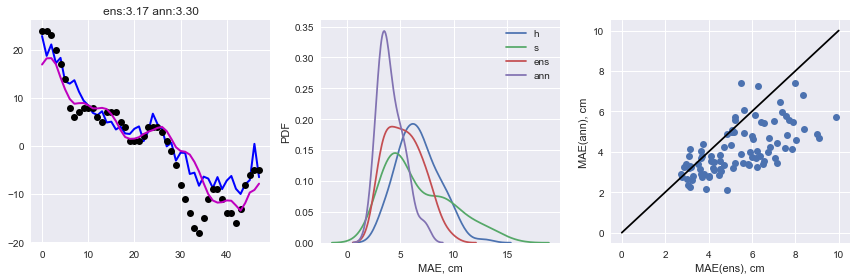

In [24]:
q = 50
predicted = estimator.predict(X)
errors_log.append(('ANN whole-forecast ensemble + data + freq', np.mean(np.abs(predicted - m_fc[8:]), axis=1)))
plot_summary(h[8:], s[8:], ens[8:], m_fc[8:], predicted, 50-8)

## Standartize

In [25]:
%%time
with tf.device('/cpu:0'):
    np.random.seed(seed)
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('mlp', KerasRegressor(build_fn=whole_fc_m_ann_ensemble, epochs=14, batch_size=10, verbose=0)))
    pipeline = Pipeline(estimators)
    kfold = KFold(n_splits=10, random_state=seed)
    esults = cross_val_score(pipeline, X, Y, cv=kfold)
    print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -60.04 (26.40) MSE
Wall time: 23.5 s


# Compare relative errors

In [26]:
for i in range(len(errors_log)):
    print(errors_log[i][0], errors_log[i][1].shape)

Basic ensemble (100,)
ANN ensemble (100,)
ANN ensemble + stadartize (100,)
ANN whole-forecast ensemble (100,)
ANN (deeper) whole-forecast ensemble (100,)
ANN (wider) whole-forecast ensemble (100,)
ANN whole-forecast ensemble + data + freq (92,)


Text(0,0.5,'PDF')

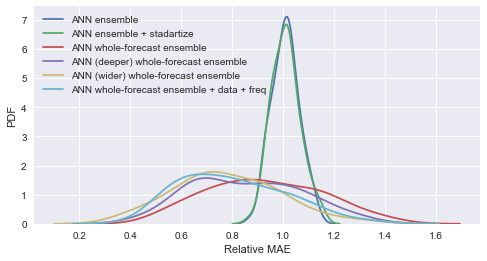

In [27]:
plt.figure(figsize=(8,4))
for i in range(1, len(errors_log)):
    sns.kdeplot(errors_log[i][1][8-N+len(errors_log[i][1]):]/errors_log[0][1][8:], label=errors_log[i][0])
plt.xlabel('Relative MAE')
plt.ylabel('PDF')